# 2D model without preprocessing

## Colab integration

In [1]:
RUNNING_IN_COLAB = True

if RUNNING_IN_COLAB:
    REPO_URL = 'https://github.com/nicomem/imed-project.git'
    REPO_DIR = 'imed-project'
    DATA_URL = 'https://drive.google.com/uc?id=1onHHWIhkhN5xYMit0rhhtVXlJrAlzCit'
    
    from pathlib import Path

    %cd /content

    # Download the repository
    if not Path(REPO_DIR).is_dir():
        !git clone {REPO_URL} {REPO_DIR} --depth=1
    
    %cd {REPO_DIR}

    # Install requirements
    !pip install -r requirements.txt | grep -v 'Requirement already satisfied'
    !pip install gdown | grep -v 'Requirement already satisfied'
    
    import gdown
    if not Path('data.zip').is_file():
        gdown.download(DATA_URL, 'data.zip', quiet=False)
    
    if not Path('data').is_dir():
        !unzip data.zip
    
    %cd notebooks
    !ls

/content
Cloning into 'imed-project'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 4), reused 10 (delta 2), pack-reused 0
Unpacking objects: 100% (15/15), done.
/content/imed-project


Downloading...
From: https://drive.google.com/uc?id=1onHHWIhkhN5xYMit0rhhtVXlJrAlzCit
To: /content/imed-project/data.zip
2.24GB [00:23, 94.3MB/s]


Archive:  data.zip
   creating: data/
   creating: data/3DT1/
  inflating: data/3DT1/0.nii.gz      
  inflating: data/3DT1/100.nii.gz    
  inflating: data/3DT1/101.nii.gz    
  inflating: data/3DT1/102.nii.gz    
  inflating: data/3DT1/103.nii.gz    
  inflating: data/3DT1/104.nii.gz    
  inflating: data/3DT1/105.nii.gz    
  inflating: data/3DT1/106.nii.gz    
  inflating: data/3DT1/107.nii.gz    
  inflating: data/3DT1/108.nii.gz    
  inflating: data/3DT1/109.nii.gz    
  inflating: data/3DT1/11.nii.gz     
  inflating: data/3DT1/110.nii.gz    
  inflating: data/3DT1/112.nii.gz    
  inflating: data/3DT1/113.nii.gz    
  inflating: data/3DT1/114.nii.gz    
  inflating: data/3DT1/115.nii.gz    
  inflating: data/3DT1/116.nii.gz    
  inflating: data/3DT1/126.nii.gz    
  inflating: data/3DT1/132.nii.gz    
  inflating: data/3DT1/137.nii.gz    
  inflating: data/3DT1/144.nii.gz    
  inflating: data/3DT1/17.nii.gz     
  inflating: data/3DT1/19.nii.gz     
  inflating: data/3DT1/2.n

## Imports

In [3]:
# 3rd-party imports
import numpy as np
import nibabel as nib
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt
import keras_unet
from tensorflow import keras

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


## Get dataset & split train/test

In [4]:
from utils.load_data import get_dataset, SlicesSequence, CachedSlicesSequence

train_nib, val_nib = get_dataset('../data', verbose=True)

Number of files for each category: 60
Train/val split: 54 / 6


In [5]:
train_nib.keys()

dict_keys(['3DT1', 'FLAIR', 'T1', 'wmh'])

In [6]:
[len(v) for v in train_nib.values()]

[54, 54, 54, 54]

In [7]:
[len(v) for v in val_nib.values()]

[6, 6, 6, 6]

## Load train & analyze

In [8]:
batch_size = 32
shuffle = True
target_height = 256
target_width = 256
img_size = (target_height, target_width)
num_classes = 1

train_seq_uncached = SlicesSequence(train_nib,
                                    target_height, target_width, 
                                    batch_size, shuffle)
train_seq = CachedSlicesSequence(train_seq_uncached, batch_size, shuffle)
len(train_seq)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


100

In [9]:
# Different number of slices & X/Y dimensions for inputs & targets
x,y = train_seq[0]
print(x.shape)
print(y.shape)
print(x[0,...,0].shape, x[0,...,1].shape, y[0].shape)

print('---')

x,y = train_seq[-1]
print(x.shape)
print(y.shape)
print(x[0,...,0].shape, x[0,...,1].shape, y[0].shape)

(32, 256, 256, 2)
(32, 256, 256)
(256, 256) (256, 256) (256, 256)
---
(32, 256, 256, 2)
(32, 256, 256)
(256, 256) (256, 256) (256, 256)


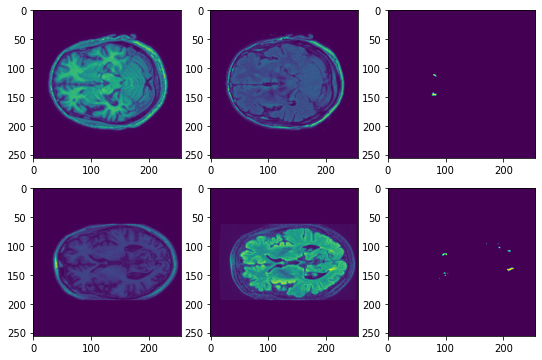

In [10]:
plt.figure(figsize=(9, 6))
i_data = 15

x,y = train_seq[0]
plt.subplot(2, 3, 1); plt.imshow(x[i_data,...,0])
plt.subplot(2, 3, 2); plt.imshow(x[i_data,...,1])
plt.subplot(2, 3, 3); plt.imshow(y[i_data])

x,y = train_seq[-1]
plt.subplot(2, 3, 4); plt.imshow(x[i_data,...,0])
plt.subplot(2, 3, 5); plt.imshow(x[i_data,...,1])
plt.subplot(2, 3, 6); plt.imshow(y[i_data])

## Prepare the model

In [11]:
from keras_unet.models import custom_unet

input_shape = (target_height, target_width, 2)
keras.backend.clear_session()
model = custom_unet(
    input_shape,
    num_classes=1,
    use_batch_norm=True,
    filters=32,
    num_layers=3,
    #dropout=0.3,
    output_activation='sigmoid'
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 576         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Train the model

In [13]:
val_seq_uncached = SlicesSequence(val_nib,
                                  target_height, target_width,
                                  batch_size, shuffle)
val_seq = CachedSlicesSequence(val_seq_uncached, batch_size, shuffle)
len(val_seq)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


11

In [14]:
val_seq.Y[107,...]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [15]:
usable_train_data = []
for i, k in enumerate(train_seq.Y):
  if np.any(k == True):
    usable_train_data.append(i)
len(usable_train_data), train_seq.Y.shape

(1314, (3222, 256, 256))

In [16]:
np.all(train_seq.Y[19,...] == train_seq.Y[usable_train_data][0]), np.any(train_seq.Y[19,...] == True)

(False, True)

In [17]:
usable_val_data = []
for i, k in enumerate(val_seq.Y):
  if np.any(k == True):
    usable_val_data.append(i)
len(usable_val_data), val_seq.Y.shape

(126, (358, 256, 256))

In [18]:
train_seq.Y = train_seq.Y.astype(np.float32)
val_seq.Y = val_seq.Y.astype(np.float32)

In [19]:
#train_seq.Y = train_seq.Y[usable_train_data]
#train_seq.X = train_seq.X[usable_train_data]

In [20]:
train_seq.X.shape, train_seq.Y.shape

((3222, 256, 256, 2), (3222, 256, 256))

In [21]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [29]:
from keras.callbacks import ModelCheckpoint


model_filename = 'segm_model_v0.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    #loss=dice_coef_loss,
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [30]:
#history = model.fit(train_seq.X[usable_train_data], train_seq.Y[usable_train_data], epochs=20, validation_data=(val_seq.X[usable_val_data], val_seq.Y[usable_val_data]))
history = model.fit(train_seq, epochs=5, validation_data=val_seq, callbacks=[callback_checkpoint])

Epoch 1/5
100/100 [==============================] - 58s 584ms/step - loss: 0.0063 - recall: 0.6586 - precision: 0.8375 - val_loss: 0.0052 - val_recall: 0.8042 - val_precision: 0.6791

Epoch 00001: val_loss improved from inf to 0.00524, saving model to segm_model_v0.h5
Epoch 2/5
100/100 [==============================] - 60s 599ms/step - loss: 0.0058 - recall: 0.6795 - precision: 0.8623 - val_loss: 0.0046 - val_recall: 0.8033 - val_precision: 0.7221

Epoch 00002: val_loss improved from 0.00524 to 0.00465, saving model to segm_model_v0.h5
Epoch 3/5
100/100 [==============================] - 61s 609ms/step - loss: 0.0054 - recall: 0.6917 - precision: 0.8573 - val_loss: 0.0044 - val_recall: 0.7771 - val_precision: 0.7564

Epoch 00003: val_loss improved from 0.00465 to 0.00444, saving model to segm_model_v0.h5
Epoch 4/5
100/100 [==============================] - 61s 609ms/step - loss: 0.0053 - recall: 0.6874 - precision: 0.8366 - val_loss: 0.0050 - val_recall: 0.8211 - val_precision: 0.561

## Check the results

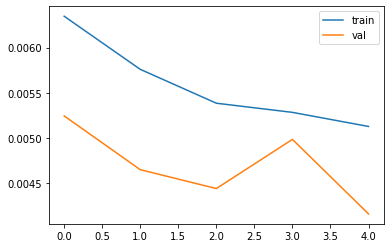

In [31]:
def rolling_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

ravg_w = 1

plt.plot(rolling_average(history.history['loss'], ravg_w), label='train')

plt.plot(rolling_average(history.history['val_loss'], ravg_w), label='val')

plt.legend()
plt.show()

In [ ]:
val_seq.X.shape

In [26]:
Y_pred = model.predict(val_seq.X)
print(Y_pred.shape)

(358, 256, 256, 1)


In [ ]:
val_seq.Y.shape

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(val_seq.Y[0, ...])
plt.subplot(1, 2, 2)
plt.imshow(Y_pred[0, ..., 0])

In [35]:
Y_pred[0]

array([[[0.00440348],
        [0.00378704],
        [0.00370263],
        ...,
        [0.00363275],
        [0.0035595 ],
        [0.00431991]],

       [[0.00399247],
        [0.00376275],
        [0.00331356],
        ...,
        [0.00363876],
        [0.00372129],
        [0.00408812]],

       [[0.00428473],
        [0.00392975],
        [0.00371955],
        ...,
        [0.00377566],
        [0.00401106],
        [0.00413746]],

       ...,

       [[0.00389994],
        [0.00372871],
        [0.00388031],
        ...,
        [0.00395266],
        [0.00393377],
        [0.00415174]],

       [[0.00413381],
        [0.00409499],
        [0.00368244],
        ...,
        [0.00381589],
        [0.00368106],
        [0.00390869]],

       [[0.00505565],
        [0.00415565],
        [0.00434   ],
        ...,
        [0.00414   ],
        [0.00429614],
        [0.00454812]]], dtype=float32)

233
179
71
97
205
224
40
181
100
247


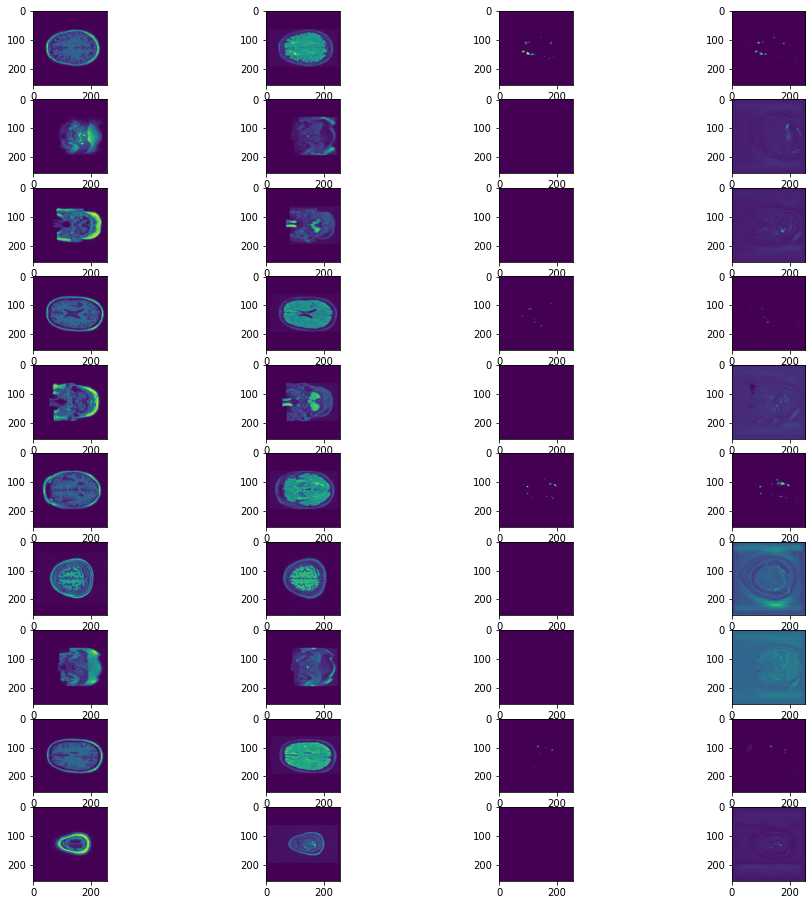

In [32]:
N = 10
i_samples = np.random.choice(np.arange(0, Y_pred.shape[0]), size=N, replace=False)

plt.figure(figsize=(16,16))
for i, i_sample in enumerate(i_samples):
  x = val_seq.X[i_sample]
  y = val_seq.Y[i_sample]
  print(i_sample)
  plt.subplot(N, 4, 4*i+1)
  plt.imshow(x[...,0])

  plt.subplot(N, 4, 4*i+2)
  plt.imshow(x[...,1])

  plt.subplot(N, 4, 4*i+3)
  plt.imshow(np.reshape(y, (target_height, target_width)))

  plt.subplot(N, 4, 4*i+4)
  plt.imshow(np.reshape(Y_pred[i_sample], (target_height, target_width)))